In [25]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import neuraltda.topology3 as tp3
import tqdm
%matplotlib inline

/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def i_c(t, tk, alpha):
    # convert t from units of tau to units of 0.01*tau = 0.01
    t /= 0.01
    usable_tk = tk[tk<t]
    a = 0.5 / 0.01

    if usable_tk.size == 0:
        current = 0
    else:
        current = alpha*np.sum(((t-usable_tk)**2 / a**2) * np.exp(-(t-usable_tk) / a))
    return current
   
def g(state):
    return 0.5*(1+np.tanh(state-2))

def network(t, state, J, c, tk, alpha):
    r = 0.5*(1+np.tanh(state - 2))
    dstate = np.dot(J, r) + c*i_c(t, tk, alpha) - state
    return dstate

def get_J(Ne, Ni, ge, gi, sd):
    J_e = sd*np.random.randn((Ne+Ni), Ne) + ge
    J_i = sd*np.random.randn((Ne+Ni), Ni) + gi
    
    J = np.hstack((J_e, J_i))
    b = (Ne+Ni)**2
    zero_entries = np.unravel_index(np.random.choice(b, size = int(0.8*b), replace=False), dims = J.shape)
    J[zero_entries] = 0
    return J

def get_c(Ne, Ni, pct):
    c = np.zeros(Ne+Ni)
    c[np.random.choice(Ne, int(pct*Ne), replace=False)] = 1
    return c.astype(int)

def get_tk(freq):
    # draw random numbers
    tk = np.random.choice(range(1, 5000), size = freq, replace=False)
    return tk

def run_trial(stim_freq, J, c, alpha, t_eval=None):
    tk = get_tk(stim_freq)
    network_func = lambda t,state: network(t, state, J, c, tk, alpha)
    out = solve_ivp(network_func, [0, 100], np.zeros(J.shape[0]), dense_output=True, rtol=1e-8, atol=1e-9, t_eval=t_eval)
    return out, tk

In [3]:
# Network Parameters
Ne = 400
Ni = 100
ge = 0.18
gi = -0.72
sd = 0.045
pct = 0.2
alpha = 4

# Get connectivity
J = get_J(Ne, Ni, ge, gi, sd)
c = get_c(Ne, Ni, pct)

# # Plot Connectivity
# plt.imshow(J)
# plt.colorbar()


/home/brad/.conda/envs/neuraltda-4/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 'shape' argument should be used instead of 'dims'


In [ ]:
import tqdm
stim_freq = 8
t = np.linspace(0, 50, 1000)
t_eval = np.arange(0, 50.01, 0.01)


n_trial = 800
print(t_eval)

In [ ]:
# fitting decoder
trial_dat = []
for trial in tqdm.tqdm(range(n_trial)):
    if trial > n_trial / 2:
        stim_freq = 16
        alpha = 1
    else:
        stim_freq = 8
        alpha = 2
        
    out, tk = run_trial(stim_freq, J, c, alpha, t_eval)
    res = g(out.sol(t_eval))
    
    
    mean_frs = np.mean(res, axis=1)
    sd_frs = np.std(res, axis=1)

    # get firing rates at end of trial
    fit_point = res[:, -1]
    fit_point_z_score = (fit_point - mean_frs) / sd_frs
    # remove direct input cells
    fit_vals = fit_point[np.abs(1-c)]
    fit_vals_z_score = fit_point_z_score[np.abs(1-c)]
    trial_dat.append((fit_vals_z_score, fit_vals, (stim_freq-8)/8.))
    

In [ ]:
trial_dat = []
for trial in tqdm.tqdm(range(n_trial)):
    if trial > n_trial / 2:
        stim_freq = 16
        alpha = 1
    else:
        stim_freq = 8
        alpha = 2
        
    out, tk = run_trial(stim_freq, J, c, alpha, t_eval)
    res = g(out.sol(t_eval))

In [ ]:
plt.figure()
for s in tk:
    plt.axvline(s*0.01)
test = plt.plot(t_eval, res.T)

In [ ]:
train_trials = trial_dat[:350] + trial_dat[400:750]
test_trials = trial_dat[350:400] + trial_dat[750:]

In [ ]:
X = np.vstack([x[0] for x in train_trials])
y = np.array([x[2] for x in train_trials])
X_test = np.vstack([x[0] for x in test_trials])
y_test = np.array([x[2] for x in test_trials])

In [ ]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X, y)
clf.score(X_test, y_test)

In [ ]:
tk = get_tk(8)
alpha = 2
i_val = [i_c(t, tk, alpha) for t in t_eval]

In [ ]:
plt.plot(t_eval, i_val)
plt.grid()


In [33]:
#topology
t_eval = np.arange(0, 100)
t_eval = np.linspace(0, 50, 1000)
trial_dat = []
n_trial = 1
stim_freq = 8
alpha=2
for trial in tqdm.tqdm(range(n_trial)):

        
    out, tk = run_trial(stim_freq, J, c, alpha, t_eval)
    res = g(out.sol(t_eval))
    randmat = np.random.random(res.shape)
    spikemat = (randmat <= res).astype(int)
    spikemat_nondriven = spikemat[np.logical_not(c), :]
    trial_spikes = np.vstack(np.nonzero(spikemat_nondriven.T)).T
    betti_curves = tp3.get_betti_curves(trial_spikes, 0, 50, 1, 1/(2e-2), 1, 4)

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


(0, 50)

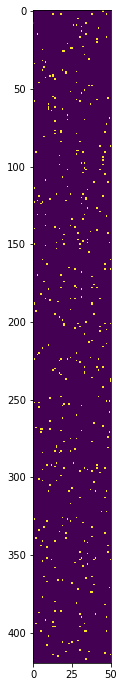

In [34]:
plt.figure(figsize=(12, 12))
plt.imshow(spikemat_nondriven)
plt.xlim([0, 50])

In [35]:
betti_curves

(array([0.00000000e+00, 5.00250125e-04, 1.00050025e-03, ...,
        9.98999500e-01, 9.99499750e-01, 1.00000000e+00]),
 {0: array([ 1.,  1.,  1., ..., 47., 47., 47.]),
  1: array([0., 0., 0., ..., 0., 0., 0.]),
  2: array([0., 0., 0., ..., 0., 0., 0.]),
  3: array([0., 0., 0., ..., 0., 0., 0.])})

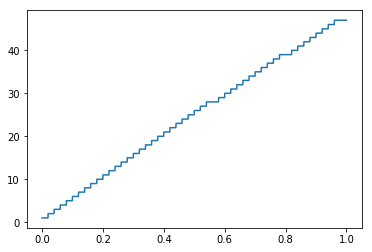

In [36]:
plt.plot(betti_curves[0], betti_curves[1][0])